# COVID-19 Research Paper K-Means Clustering

Create clusters in the data using the abstracts of each paper, using the K-means clustering algorithm.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import nltk
from nltk.stem.snowball import SnowballStemmer

import re

In [2]:
"""Convert metadata.csv to a df_abstracts, which contains the sha and abstracts of every valid paper.
-read in metadata.csv to a df
-filter out rows without a full text file
-filter out rows with multiple corresponding full text files
-create df_abstracts, which contains sha and abstracts for all valid papers
"""

df = pd.read_csv("CORD-19-research-challenge/metadata.csv")
df_with_full = df.loc[df['has_full_text'] == True].drop(columns = 'has_full_text')

df_custom_license = df_with_full.loc[df_with_full['full_text_file'].str.match("custom_license")]
df_noncomm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("noncomm_use_subset")]
df_comm_use_subset = df_with_full.loc[df_with_full['full_text_file'].str.match("comm_use_subset")]
df_biorxiv_medrxiv = df_with_full.loc[df_with_full['full_text_file'].str.match("biorxiv_medrxiv")]

invalid_rows = []
for index, row in df_custom_license.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)

df_custom_license = df_custom_license.drop(invalid_rows)

invalid_rows = []
for index, row in df_noncomm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_noncomm_use_subset = df_noncomm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_comm_use_subset.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_comm_use_subset = df_comm_use_subset.drop(invalid_rows)

invalid_rows = []
for index, row in df_biorxiv_medrxiv.iterrows():
    if ";" in row['sha']:
        invalid_rows.append(index)
        
df_biorxiv_medrxiv = df_biorxiv_medrxiv.drop(invalid_rows)

df_all = pd.concat([df_custom_license, df_noncomm_use_subset, df_comm_use_subset, df_biorxiv_medrxiv])

df_abstracts = df_all[['sha','abstract']]

df_abstracts.to_csv("abstracts.csv")

In [3]:
"""Take sample of rows from df_abstracts to reduce runtime"""

df_abstracts_partial = df_abstracts.sample(n=10000)
df_abstracts_partial = df_abstracts_partial.dropna()

In [4]:
"""Remove rows with bad input in abstract column"""

abstract_list = df_abstracts_partial["abstract"].values
abstract_list = [x for x in abstract_list if str(x) != 'nan']
type(abstract_list)

list

In [5]:
"""Check to make sure all abstract values are strings"""

bad_inputs = 0
for i in abstract_list:
    if type(i) != str:
        bad_inputs += 1
bad_inputs

0

In [6]:
""" Takes in abstract_list, returns abstract_list_stemmed, which contains the same list
of strings but with each word converted to reduce variability
"""

snowBallStemmer = SnowballStemmer("english")

abstract_list_stemmed = []

# adapted from http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [snowBallStemmer.stem(word) for word in words]
    return words

for i in abstract_list:
    words_list = stemming_tokenizer(i)
    words_paragraph = ""
    for j in words_list:
        words_paragraph = words_paragraph + " " + j
    abstract_list_stemmed.append(words_paragraph)

In [7]:
"""Creares a df of TFIDF vectorized abstracts

TF-IDF (term frequency-inverse document frequency) is a statistical
measure that evaluates how relevant a word is to a document in a collection.

adapted from https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

token_pattern=r'(?u)\b[A-Za-z]+\b' filters out non-alphabetical characters
"""

vectorizer = TfidfVectorizer(min_df = 10, max_df = 0.9, max_features = 150, stop_words = 'english', token_pattern=r'(?u)\b[A-Za-z]+\b')
vectors = vectorizer.fit_transform(abstract_list_stemmed)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [8]:
df.drop(["abstract"], axis=1)

,acid,activ,acut,addit,age,agent,analysi,anim,antibodi,antigen,...,test,time,transmiss,treatment,type,use,vaccin,viral,virus,year
0,0.000000,0.265158,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.310086,0.000000,0.0,0.111611,0.087070,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.068566,0.0,0.087265,0.136155,0.000000
2,0.000000,0.000000,0.129410,0.000000,0.000000,0.000000,0.000000,0.0,0.148248,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,0.276024,0.000000,0.118662,0.000000,0.000000,0.137435,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.072012,0.0,0.091652,0.142999,0.000000
4,0.154890,0.488740,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.130360,0.0,0.0,0.0,0.000000,0.080819,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8693,0.000000,0.000000,0.000000,0.000000,0.396893,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.520225
8694,0.000000,0.000000,0.000000,0.192199,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.229304,0.0,0.145920,0.113835,0.000000
8695,0.114486,0.000000,0.196870,0.000000,0.000000,0.000000,0.093814,0.0,0.000000,0.0,...,0.096355,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
8696,0.000000,0.000000,0.000000,0.122262,0.143568,0.000000,0.229075,0.0,0.000000,0.0,...,0.117639,0.0,0.0,0.0,0.386833,0.072933,0.0,0.000000,0.000000,0.000000


In [9]:
df

,abstract,acid,activ,acut,addit,age,agent,analysi,anim,antibodi,...,test,time,transmiss,treatment,type,use,vaccin,viral,virus,year
0,0.0,0.000000,0.265158,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.310086,0.000000,0.0,0.111611,0.087070,0.000000
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.068566,0.0,0.087265,0.136155,0.000000
2,0.0,0.000000,0.000000,0.129410,0.000000,0.000000,0.000000,0.000000,0.0,0.148248,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,0.0,0.276024,0.000000,0.118662,0.000000,0.000000,0.137435,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.072012,0.0,0.091652,0.142999,0.000000
4,0.0,0.154890,0.488740,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.130360,0.0,0.0,0.0,0.000000,0.080819,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8693,0.0,0.000000,0.000000,0.000000,0.000000,0.396893,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.520225
8694,0.0,0.000000,0.000000,0.000000,0.192199,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.229304,0.0,0.145920,0.113835,0.000000
8695,0.0,0.114486,0.000000,0.196870,0.000000,0.000000,0.000000,0.093814,0.0,0.000000,...,0.096355,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
8696,0.0,0.000000,0.000000,0.000000,0.122262,0.143568,0.000000,0.229075,0.0,0.000000,...,0.117639,0.0,0.0,0.0,0.386833,0.072933,0.0,0.000000,0.000000,0.000000


In [10]:
"""Apply PCA to normalized TF-IDF document vectors to reduce number of dimensions to help with K-means clustering.
Used a threshold value of 0.85 to ensure the reduced dimension vectors account for 85% of the variance."""

# adapted from https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components = 0.85)
standardized_values = StandardScaler().fit_transform(df.values)
principal_components = pca.fit_transform(standardized_values)
reduced_df = pd.DataFrame(data = principal_components)
reduced_df

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,3.789659,0.653122,-1.338997,2.616314,1.538682,0.660551,0.561776,0.641693,-1.546309,2.161245,...,0.012962,0.016794,-0.434815,0.033076,1.414768,-0.706743,-0.806773,0.684771,0.255495,-0.449410
1,1.152418,-0.799941,-0.890799,0.971201,0.331040,-2.704690,-1.913892,1.571242,0.828344,-0.731503,...,-1.227115,1.288527,0.256672,0.577510,0.767981,-0.323636,-0.172044,0.176515,-0.274303,-0.150986
2,-0.667567,-0.403197,4.579493,4.875748,-3.619968,3.255905,1.780584,0.549728,1.723515,-0.403242,...,-0.481657,-1.014935,0.183319,-1.250341,0.177002,0.336507,0.719009,-0.882063,0.694254,-0.945608
3,-0.018371,2.929239,1.360784,-3.080510,-2.340440,-0.846572,-1.669301,0.802795,0.999557,0.083868,...,1.128676,-0.575086,0.063465,-0.764287,0.420606,-0.622149,0.135181,1.155034,-0.284865,0.111698
4,3.137632,1.522766,-3.136637,-0.347150,-1.758614,0.521390,1.303934,0.227405,-0.645478,-0.529972,...,2.151265,-0.551450,0.497834,1.434508,-0.523924,-0.638462,-0.144833,-0.299008,-0.372457,-0.875796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8693,-3.921784,0.279521,-2.108345,1.003400,-1.737410,-0.423956,-1.922627,-3.662291,-1.955834,-0.340923,...,-0.005540,-0.227443,-1.013513,-0.564706,0.004104,-1.331347,-0.595728,-0.374980,-0.804888,0.148886
8694,1.047414,-1.179329,-0.128562,-0.891834,0.216135,-3.319168,0.189573,-0.279640,1.484483,0.185178,...,-0.556861,-0.551996,0.868013,-0.613382,0.903380,0.140992,0.624605,0.160067,-1.098785,1.251891
8695,-2.711120,3.613075,0.896002,0.140099,0.713618,-1.401319,-0.026630,0.161368,1.818122,-0.509507,...,-0.315311,0.059811,-0.277293,-0.152608,0.437957,-0.176180,-0.058874,0.383921,-0.833508,-0.207996
8696,-1.219610,3.733029,1.705370,-2.714564,0.473696,0.067571,-2.843095,0.200441,-0.039359,-2.371401,...,-0.020582,1.021485,-0.046779,-0.144052,0.287032,0.400516,0.344519,0.002146,-1.036563,-0.062378


In [11]:
"""100 most relevant features"""

(reduced_df.columns)

RangeIndex(start=0, stop=113, step=1)

sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity
sanity


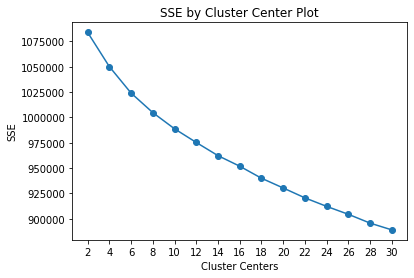

In [12]:
"""Creates an elbow plot to identify the ideal number of clusters based on sum of squared errors

copied from https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
"""

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, n_init=20).fit(data).inertia_)
        #sse.append(MiniBatchKMeans(n_clusters=k, batch_size=2048, random_state=20).fit(data).inertia_)
        #print('Fit {} clusters'.format(k))
        print("sanity")
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(reduced_df, 30)

In [13]:
"""Displays an example of the TFIDF vector for a single paper"""

row_dict = df.loc[ 0 , : ].to_dict()

from collections import OrderedDict

dd = OrderedDict(sorted(row_dict.items(), key=lambda x: x[1], reverse=True))
dd

OrderedDict([('ifn', 0.6433891191426064),
             ('antivir', 0.34563879677027576),
             ('type', 0.3100856644708997),
             ('immun', 0.28739019598166377),
             ('activ', 0.2651584169707269),
             ('cell', 0.22337677383413082),
             ('infect', 0.17580042397849027),
             ('inhibit', 0.17269014624512757),
             ('protect', 0.1685996839128021),
             ('factor', 0.14818888896723786),
             ('express', 0.14250644763532516),
             ('specif', 0.1271697566265072),
             ('viral', 0.11161087515636098),
             ('virus', 0.08706981290388152),
             ('abstract', 0.0),
             ('acid', 0.0),
             ('acut', 0.0),
             ('addit', 0.0),
             ('age', 0.0),
             ('agent', 0.0),
             ('analysi', 0.0),
             ('anim', 0.0),
             ('antibodi', 0.0),
             ('antigen', 0.0),
             ('approach', 0.0),
             ('assay', 0.0),
            

In [14]:
"""Adds assigned cluster cloumn to df_partial_abstracts."""

clusters = KMeans(n_clusters=14).fit_predict(df)

df_abstracts_partial["cluster"] = clusters
df_abstracts_partial.sort_values("cluster")

,sha,abstract,cluster
21266,ec9ad2ac0be589d617f25f1cfc349f644d1bebf1,To evaluate the most controversial issue conce...,0
6298,aa8c1dae28ba8fb4664d2ec9e8632cd1673da721,Abstract The emergence of new infectious bronc...,0
23140,105268027d44ab275991e358674462f77223e882,Porcine epidemic diarrhea virus (PEDV) was det...,0
20685,b1d4318370f0bf32b2c6afded3ef07c1a37abe7a,The mammalian tick-borne flavivirus group (MTB...,0
26994,a41e8928ee5cb212550be0620946d6e62c34b001,OBJECTIVES AND DESIGN: Developing an effective...,0
...,...,...,...
1044,c7937fb94dc25050380469af023ed5bca032c62e,Abstract A series of recombinant fusion protei...,13
41699,c745ca78351211b549476ef12e4cccf3fc3f5b84,"Within the last 15 years, two related coronavi...",13
8653,e25faf74cd21615fc0254665755a19618ced6d99,Abstract The severe acute respiratory syndrome...,13
23251,945fd47a82b49774675d732d27f6b806c0e6aeb1,Interferon-induced transmembrane (IFITM) prote...,13


In [15]:
clustercounts = df_abstracts_partial[["abstract", "cluster"]]
clustercounts = clustercounts.groupby("cluster", as_index=False).count().sort_values("cluster", ascending=True)
clustercounts

,cluster,abstract
0,0,589
1,1,622
2,2,579
3,3,568
4,4,465
5,5,594
6,6,509
7,7,703
8,8,949
9,9,464


([<matplotlib.axis.XTick at 0x1a245c0190>,
 <a list of 14 Text xticklabel objects>)

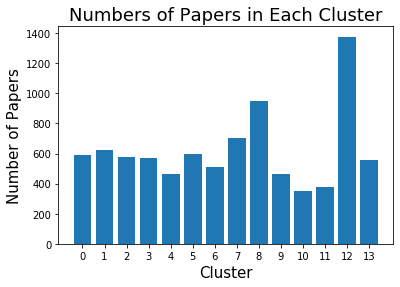

In [16]:
# plt.figure(figsize=(10,6))
# bar plot with matplotlib
plt.bar('cluster', 'abstract', data=clustercounts)
plt.xlabel("Cluster", size=15)
plt.ylabel("Number of Papers", size=15)
plt.title("Numbers of Papers in Each Cluster", size=18)
plt.xticks(clustercounts["cluster"].values)

In [17]:
"""Use t-SNE to reduce the >100 dimensional points to two dimensions."""

from sklearn.manifold import TSNE

tsne_results = TSNE(n_components=2).fit_transform(reduced_df)

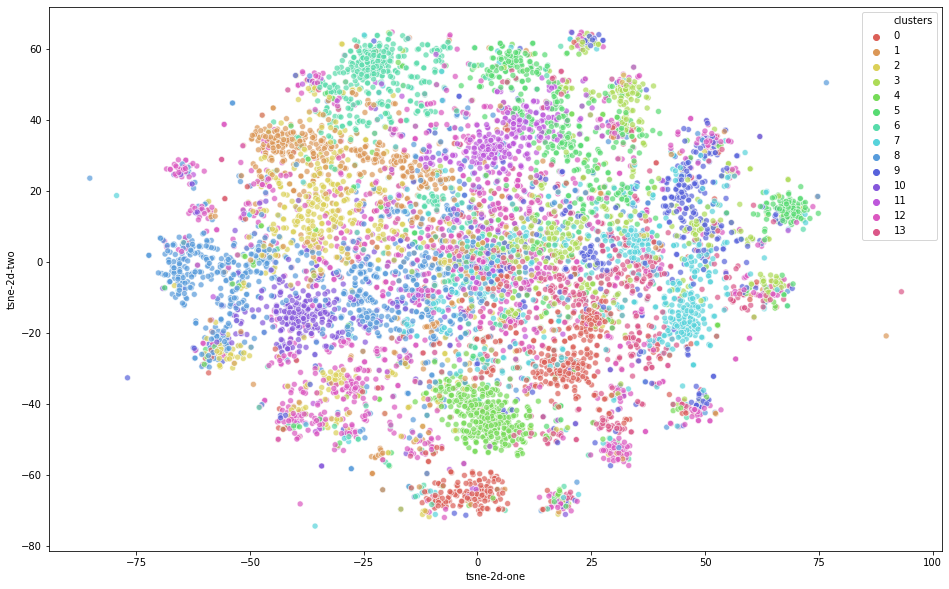

In [19]:
"""Use the results of t-SNE to visualize the clusters on a two dimensional plot."""

# adapted from https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

df_tsne = pd.DataFrame()

df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne["clusters"] = clusters

plt.figure(figsize=(16,10))
sns.scatterplot(
    x='tsne-2d-one',
    y='tsne-2d-two',
    data=df_tsne,
    palette=sns.color_palette("hls", 14),
    legend="full",
    alpha=0.7,
    hue="clusters"
)

In [21]:
df_abstracts_partial

,sha,abstract,cluster
2253,9ecbafcacb742424c9f3fd6cb7c211798dd32b85,The concept of ‘innate immunity’ embraces all ...,5
25698,2af1bd7a71e67484330a168ec2aa07e383cef140,Lassa virus (LASV) and Mopeia virus (MOPV) are...,3
28484,38731c8391dd2178df3d10c3db375d000428407d,Whether severe acute respiratory syndrome–asso...,4
21269,94156e6941fe78191b5997cdeb10cb3fd06e1221,BACKGROUND: Acute viral necrosis virus (AVNV) ...,0
22881,44f82307e441f32a4ddd4ea51a8f823c593e2151,The roots and rhizomes of Glycyrrhiza species ...,9
...,...,...,...
14469,6c47de6cdb3b6fff17d0fd819a7a3dba678a939d,Objectives 1) To compare the 2-year completed ...,12
13657,fa35fd91a2a17e77a0e727dca2b0d0e751171122,Recent advances in host–microbe interaction st...,7
28309,07fe504a3b64db4dd23da77929893eb89215f3be,OBJECTIVE: Human bocavirus (HBoV) is a recentl...,2
28498,99ad07c4a0fdcc24df76b723ff978c84076c56ac,The presence of turkey astrovirus (TAstV) was ...,0
